# Импорт библиотек

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

# Загрузка данных

In [2]:
# Переведем данные в привычный нам NumPy формат
mat_data = scipy.io.loadmat('./frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


In [3]:
# Подготовка torch датасета
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

## Задание 1. Разделите данные на `train` и `val` части. К `val` отнесите последние 300 объектов. Подготовьте данные для обучения с помощью `FreyDataset` и `DataLoader`.

In [4]:
x_train = FreyDataset(data[:-300])
x_val = FreyDataset(data[-300:])
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [5]:
batch_size = 64

train_loader = DataLoader(dataset=x_train, batch_size=batch_size, shuffle=True, num_workers=20)
val_loader = DataLoader(dataset=x_val, batch_size=batch_size, shuffle=False, num_workers=20)

In [6]:
data.shape

(1965, 1, 28, 20)

# Вариационныей автоэнкодер

## Задание 2. Допишите трюк репараметризации в функции `reparameterize`. 

*Подробнее о трюке можно узнать в [дополнительных материалах](https://drive.google.com/file/d/18LWM4jROW6A89B7XEpH6w66M5BomGUKn/view?usp=sharing).*

In [7]:
class ConvVAE(nn.Module):
    def __init__(self, kernel_size=3, stride=1, padding=0, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.Conv2d(512, 2*latent_dim, kernel_size=kernel_size, stride=stride, padding=padding)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.Sigmoid(),
        )
    def reparameterize(self, mu:torch.Tensor, logvar:torch.Tensor):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        latent_dist = eps * std + mu
        return latent_dist
 
    def forward(self, x:torch.Tensor):
        x = self.encoder(x)
        mu, logvar = x.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        x = self.decoder(z)
        return x, mu, logvar

In [8]:
lr = 1e-3
epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCELoss(reduction='mean')
kl_div = nn.KLDivLoss(reduction='batchmean')
mse = nn.MSELoss(reduction='mean')

## Задание 3. Прежде, чем перейти к обучению модели, определите функцию потерь VAE.

$$ \text{KL Loss}(\mu, \sigma) = -\frac{1}{2}[1 + \log(\sigma^2) -\mu^2 - \sigma^2] $$

In [10]:
def KLDivLoss(mu:torch.Tensor, logvar:torch.Tensor):
    var = torch.exp(logvar)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - var)
    return kl_div

## Обучение модели

In [11]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(x_train)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        # bce_loss = criterion(reconstruction, data)
        kl_loss = KLDivLoss(mu, logvar)
        # kl_loss = kl_div(reconstruction, data)
        mse_loss = mse(reconstruction, data)
        loss = kl_loss + mse_loss
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [12]:
def validate(model, dataloader, epoch):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(x_val)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            # bce_loss = criterion(reconstruction, data)
            kl_loss = KLDivLoss(mu, logvar)
            # kl_loss = kl_div(reconstruction, data)
            mse_loss = mse(reconstruction, data)
            loss = kl_loss + mse_loss
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(x_val)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(both.cpu(), f"./output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [13]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 20


27it [00:00, 46.20it/s]                        
5it [00:00, 79.74it/s]               

Train Loss: 0.1723
Val Loss: 0.0007
Epoch 2 of 20



27it [00:00, 80.63it/s]                        
5it [00:00, 126.69it/s]              

Train Loss: 0.0003
Val Loss: 0.0003
Epoch 3 of 20



27it [00:00, 83.06it/s]                        
5it [00:00, 119.78it/s]              

Train Loss: 0.0002
Val Loss: 0.0003
Epoch 4 of 20



27it [00:00, 82.74it/s]                        
5it [00:00, 122.61it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 5 of 20



27it [00:00, 80.41it/s]                        
5it [00:00, 121.75it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 6 of 20



27it [00:00, 89.25it/s]                        
5it [00:00, 115.03it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 7 of 20



27it [00:00, 87.41it/s]                        
5it [00:00, 135.94it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 8 of 20



27it [00:00, 86.58it/s]                        
5it [00:00, 101.98it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 9 of 20



27it [00:00, 83.94it/s]                        
5it [00:00, 124.36it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 10 of 20



27it [00:00, 86.41it/s]                        
5it [00:00, 127.15it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 11 of 20



27it [00:00, 87.72it/s]                        
5it [00:00, 122.62it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 12 of 20



27it [00:00, 85.64it/s]                        
5it [00:00, 142.31it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 13 of 20



27it [00:00, 81.30it/s]                        
5it [00:00, 113.57it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 14 of 20



27it [00:00, 81.44it/s]                        
5it [00:00, 123.00it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 15 of 20



27it [00:00, 81.40it/s]                        
5it [00:00, 136.23it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 16 of 20



27it [00:00, 82.61it/s]                        
5it [00:00, 115.61it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 17 of 20



27it [00:00, 83.03it/s]                        
5it [00:00, 126.67it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 18 of 20



27it [00:00, 82.93it/s]                        
5it [00:00, 128.37it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 19 of 20



27it [00:00, 81.60it/s]                        
5it [00:00, 123.47it/s]              

Train Loss: 0.0002
Val Loss: 0.0002
Epoch 20 of 20



27it [00:00, 81.95it/s]                        
5it [00:00, 122.02it/s]              

Train Loss: 0.0002
Val Loss: 0.0002


## Визуализация полученных изображений

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

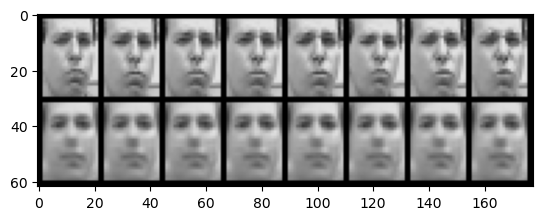

In [15]:
# 10я эпоха
image_10 = Image.open("output10.png")
plt.imshow(image_10)

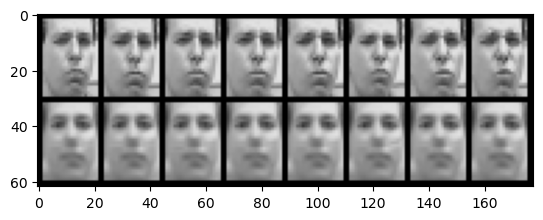

In [16]:
# 19я эпоха
image_19 = Image.open("output19.png")
plt.imshow(image_19)

In [68]:
next(iter(val_loader)).shape

torch.Size([64, 1, 28, 20])

In [75]:
x_val[0].expand(1, -1, -1, -1).shape

torch.Size([1, 1, 28, 20])

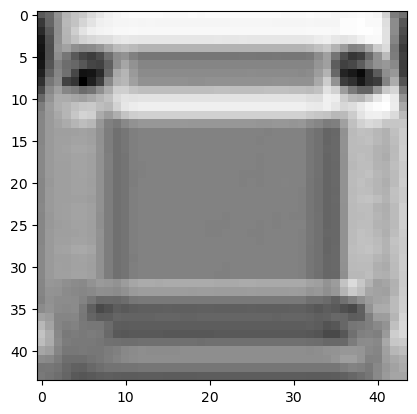

In [90]:
# Получите случайное значение z из распределения параметров скрытого пространства
z = torch.rand((1, 2, 30, 30)).cuda()

# Отбросьте энкодер и передайте z в декодер
x = model.decoder(z)
# Получите восстановленное изображение от декодера
image = x.cpu().detach().numpy()[0]

# Преобразуйте восстановленное изображение в формат, который можно отобразить
image = image * 255
image = image.astype(np.uint8)

# Отобразите восстановленное изображение
plt.imshow(image[0], cmap='gray')
plt.show()